In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

tick = yf.Ticker("MSFT")
#sbin = tick.history(start=date(2000,1,1), end=date(2020,11,1))
#sbin = tick.history(period="max")
sbin = tick.history(period="1y")


print(sbin.head())

                                 Open        High         Low       Close  \
Date                                                                        
2022-08-24 00:00:00-04:00  272.774785  274.577378  272.477637  273.151154   
2022-08-25 00:00:00-04:00  274.676409  276.350241  271.893299  276.181885   
2022-08-26 00:00:00-04:00  276.409676  277.657630  265.415908  265.524841   
2022-08-29 00:00:00-04:00  263.306293  264.841450  261.325430  262.692230   
2022-08-30 00:00:00-04:00  264.118405  264.494744  258.165902  260.453796   

                             Volume  Dividends  Stock Splits  
Date                                                          
2022-08-24 00:00:00-04:00  18137000        0.0           0.0  
2022-08-25 00:00:00-04:00  16583400        0.0           0.0  
2022-08-26 00:00:00-04:00  27549300        0.0           0.0  
2022-08-29 00:00:00-04:00  20338500        0.0           0.0  
2022-08-30 00:00:00-04:00  22767100        0.0           0.0  


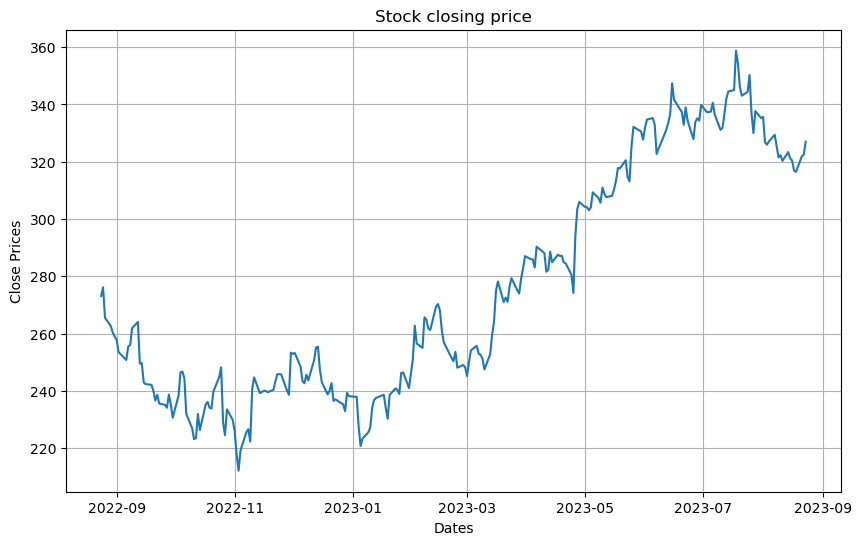

In [2]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(sbin['Close'])
plt.title('Stock closing price')
plt.show()

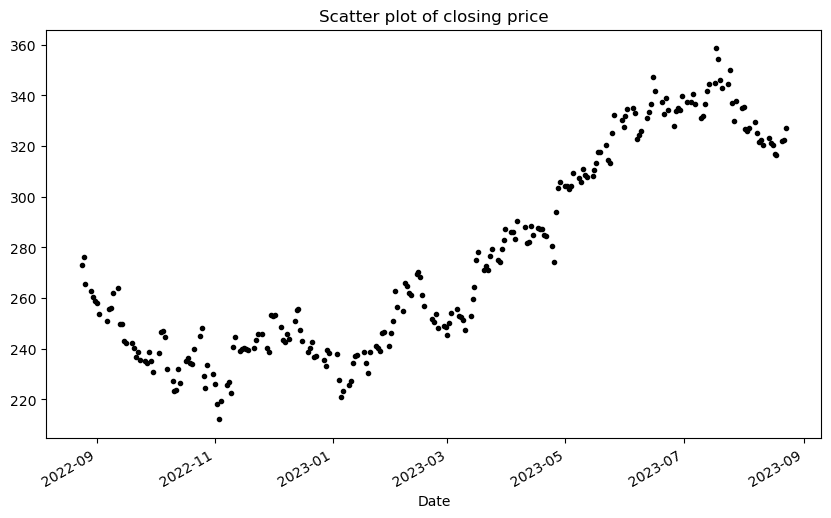

In [3]:
plt.figure(figsize=(10,6))
df_close = sbin['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

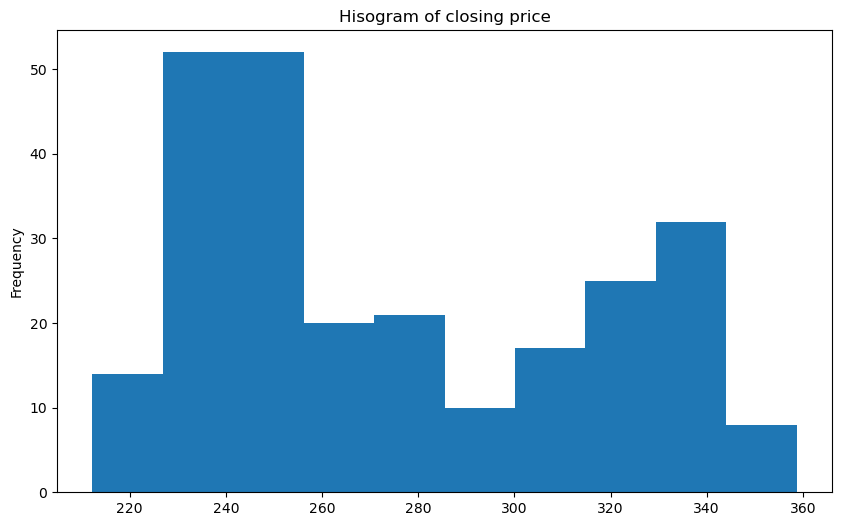

In [4]:
plt.figure(figsize=(10,6))
df_close = sbin['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.
Testing For Stationarity:
To identify the nature of the data, we will be using the null hypothesis.<br>
H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt.<br>
H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0.

#Ho: It is non-stationary<br>
#H1: It is stationary
If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

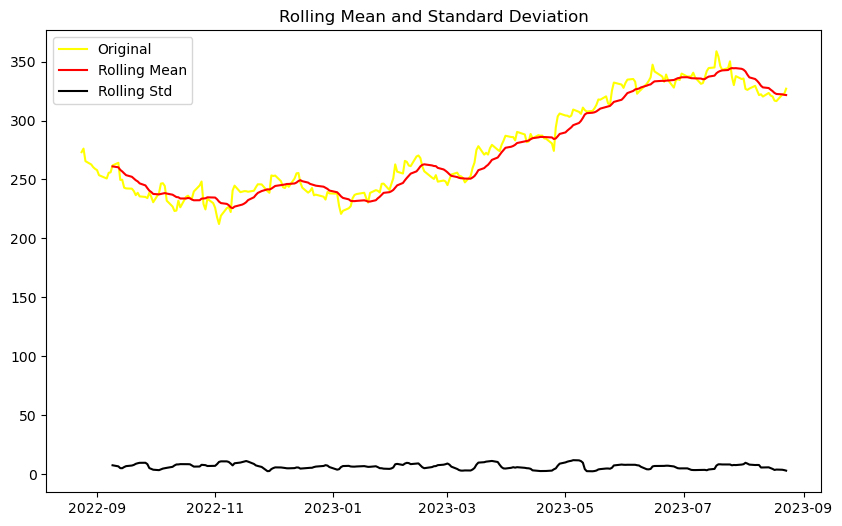

Results of dickey fuller test
Test Statistics                 -0.434436
p-value                          0.904188
No. of lags used                 2.000000
Number of observations used    248.000000
critical value (1%)             -3.456996
critical value (5%)             -2.873266
critical value (10%)            -2.573019
dtype: float64


In [5]:
from statsmodels.tsa.stattools import adfuller
# Define a function to test stationarity of a time series
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()# Rolling mean with window size of 12
    rolstd = timeseries.rolling(12).std()# Rolling standard deviation with window size of 12
    # Plot the original time series, rolling mean, and rolling standard deviation
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    # Perform the Dickey-Fuller test for stationarity
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')# ADF test with automatic lag selection
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    # Loop through critical values and add them to the output series
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(sbin['Close'])

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

<Figure size 1000x600 with 0 Axes>

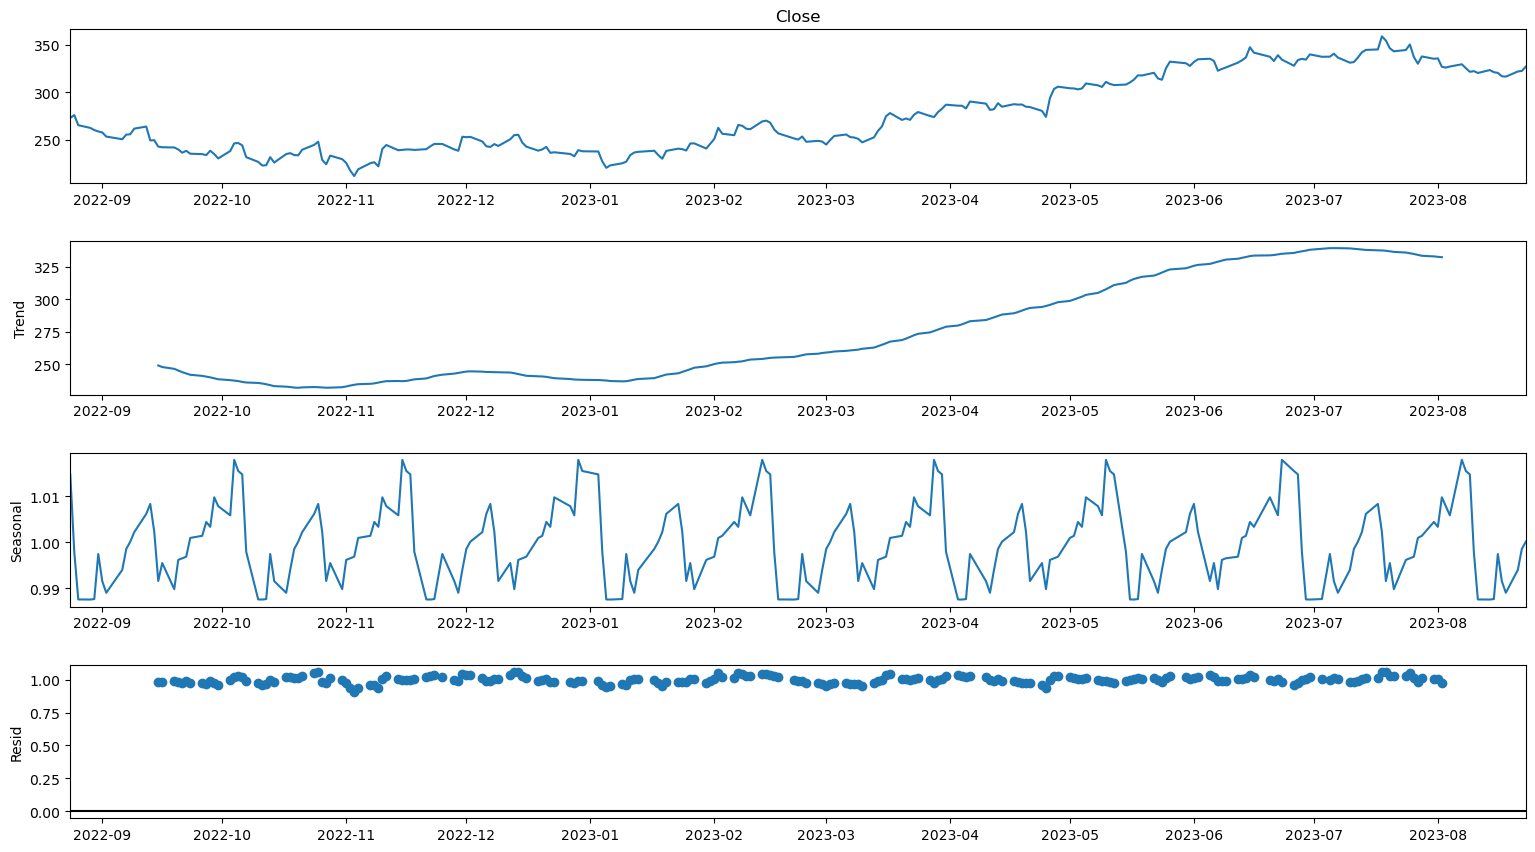

In [6]:
# Perform seasonal decomposition on the 'df_close' time series data
# using a multiplicative model and a seasonal period of 30
result = seasonal_decompose(df_close, model='multiplicative', period = 30)# assuming the data has a seasonal pattern repeating every 30 periods
fig = plt.figure() 
# Plot the seasonal decomposition components
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


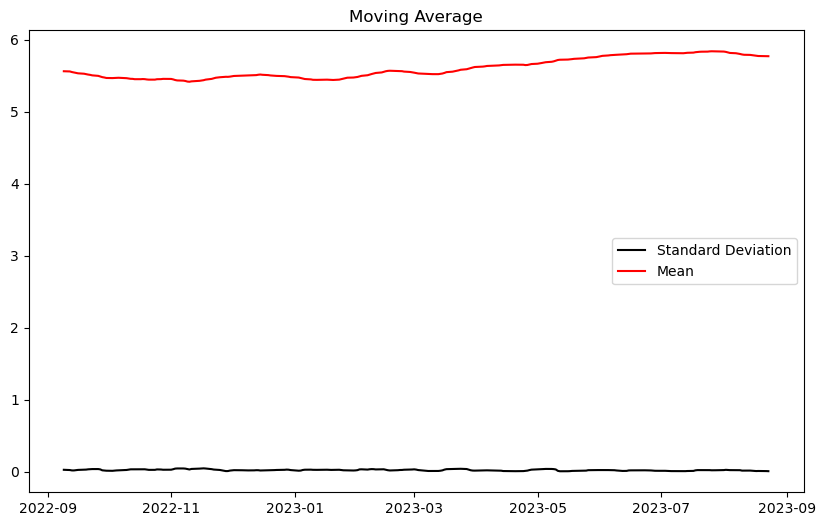

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(sbin['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

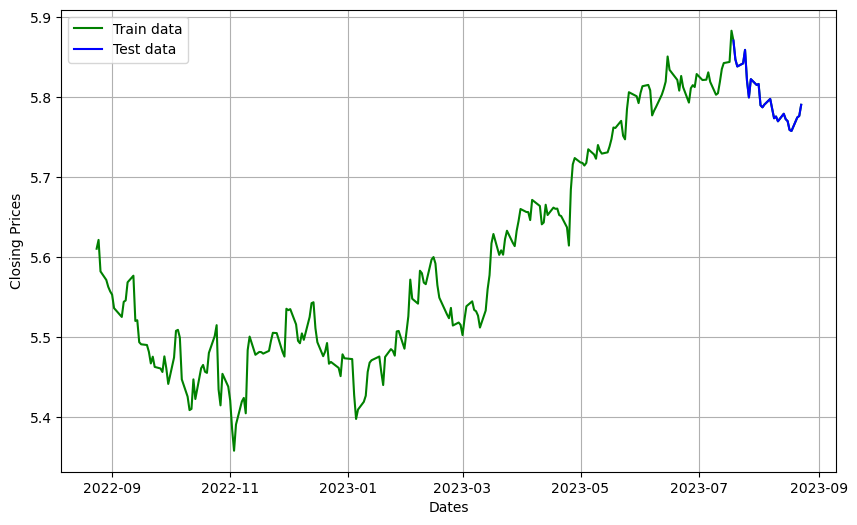

In [8]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [9]:
model_autoARIMA = auto_arima(
    train_data, 
    start_p=0,        # Starting value of p (order of autoregressive term)
    start_q=0,        # Starting value of q (order of moving average term)
    test='adf',       # use adftest to find optimal 'd' (differencing parameter)
    max_p=3, max_q=3, # maximum p and q
    m=1,              # frequency of series (seasonal period)
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality assumed
    start_P=0,        # Starting value of seasonal P
    D=0,              # Seasonal differencing parameter
    trace=True,       # Print debugging information
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True     # Use stepwise algorithm to find best model
)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1094.154, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1093.489, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1094.420, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1095.077, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1097.111, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1100.448, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1101.873, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1100.216, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1098.152, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1102.477, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1094.557, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-1100.723, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1100.864, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1098.169, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0

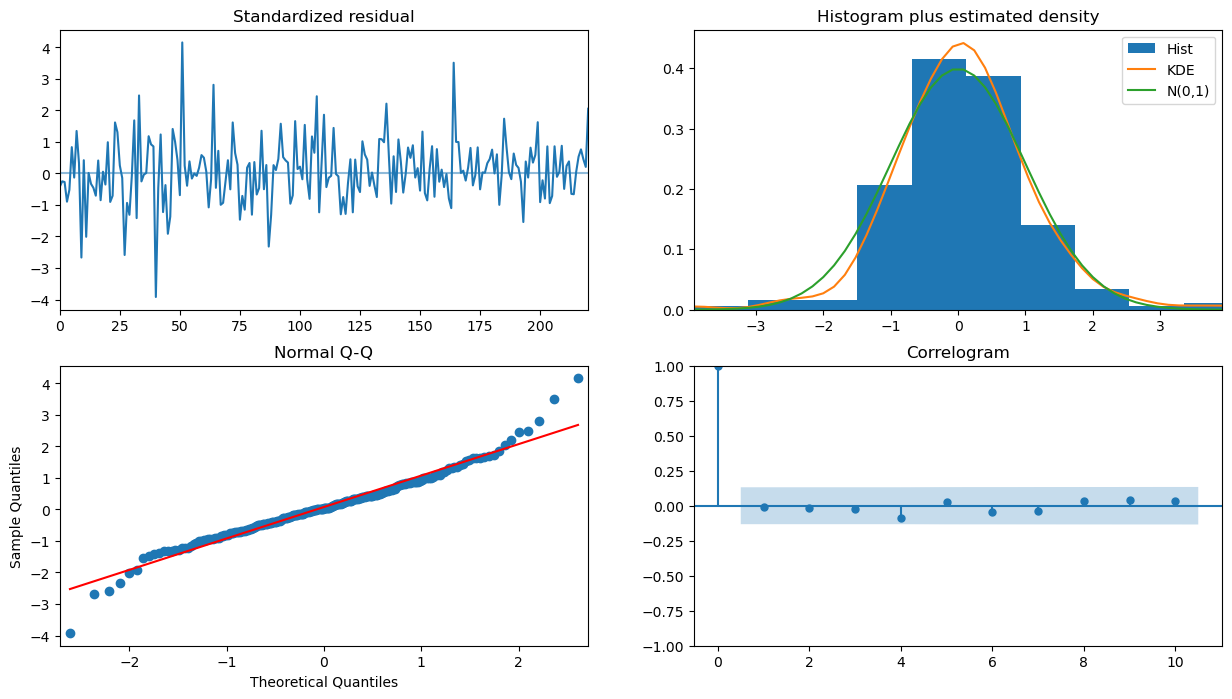

In [10]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
model = ARIMA(train_data, order=(2, 1, 0)) #(p,d,q) choose best model finded
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 554.239
Date:                Thu, 24 Aug 2023   AIC                          -1102.477
Time:                        09:59:57   BIC                          -1092.283
Sample:                             0   HQIC                         -1098.361
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0995      0.079      1.259      0.208      -0.055       0.254
ar.L2         -0.2121      0.066     -3.236      0.001      -0.341      -0.084
sigma2         0.0004   2.67e-05     14.515      0.0

C:\Users\david\anaconda3\envs\notebook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\david\anaconda3\envs\notebook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\david\anaconda3\envs\notebook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\david\anaconda3\envs\notebook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\david\anaconda3\envs\notebook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


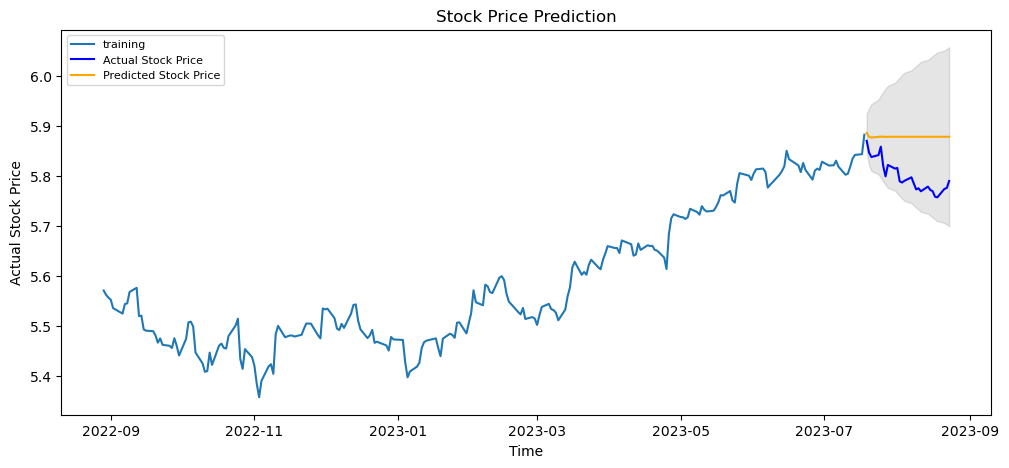

In [12]:
# Forecast
fc = fitted.forecast(len(test_data))
forecast = fitted.get_forecast(len(test_data))
se = forecast.se_mean
conf = forecast.conf_int(alpha=0.05)

fc.index=test_data.index
fc_series = fc

lower_series = conf["lower Close"]
lower_series.index=test_data.index

upper_series = conf["upper Close"]
upper_series.index=test_data.index
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.007283458821843393
MAE: 0.07973499657269957
RMSE: 0.08534318263249498
MAPE: 0.013778451577644556


In conclusion, we can observe how stock prices are mostly random, which is evident from the fact that ARIMA tends to predict prices parallel to the x-axis. This indicates that it hasn't identified recurring patterns or specific structures in the trend of prices used as the training set. This could certainly be attributed to the model's inability to capture phenomena arising from external factors and its modest complexity. However, the main aspect to note is the similarity between stock prices and a random walk.